In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [33]:
%cd /kaggle/input/food-101/
!head 'food-101/food-101/meta/train.txt'

/kaggle/input/food-101
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [4]:
#Read Training and Test data
train = pd.read_csv('food-101/food-101/meta/train.txt', header = None, names=['path'])
test = pd.read_csv('food-101/food-101/meta/test.txt', header = None, names=['path'])

In [5]:
def spliter(data, class_or_id='id'):
    if class_or_id.upper() == 'CLASS':
        output = data.split('/')[0]
        
    else:
        output = data.split('/')[-1]
    return output

In [6]:
train['label'] = train['path'].map(lambda x: spliter(data = x, class_or_id = 'Class')) 
train['idx'] = train['path'].map(lambda x: spliter(x)) 
test['label'] = test['path'].map(lambda x: spliter(x, 'class')) 
test['idx'] = test['path'].map(lambda x: spliter(x)) 

In [7]:
Classes = train['label'].unique()[:20]
print(Classes)

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheesecake' 'cheese_plate' 'chicken_curry'
 'chicken_quesadilla']


In [8]:
Labels = []
for c in Classes:
    Labels.append(c.upper())
Classes = [i.upper() for i in Classes]
def format_classes(label):
    if label.upper() in Classes:
        return label
    else:
        return 'others'

train['label'] = train['label'].map(lambda x: format_classes(x))
test['label'] = test['label'].map(lambda x: format_classes(x))
print(train['label'].unique())

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheesecake' 'cheese_plate' 'chicken_curry'
 'chicken_quesadilla' 'others']


In [9]:
def Define_Path(path):
    return 'food-101/food-101/images/'+path+'.jpg'
train['path'] = train[['path']].apply(Define_Path, axis=1)
test['path'] = test[['path']].apply(Define_Path, axis=1)


In [10]:
test_images = plt.imread(test['path'].iloc[114])
test_images = test_images/255.
test_images.shape

(512, 512, 3)

(512, 512, 3)

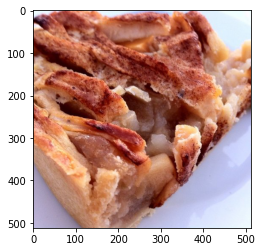

In [11]:
train_images = plt.imread(train['path'].iloc[13])
plt.imshow(train_images)
train_images.shape

In [12]:
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.xception import Xception

In [13]:
datagen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

In [14]:
test_generator = datagen.flow_from_dataframe(dataframe = test, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb', 
    classes=None, class_mode='categorical', batch_size=32,shuffle=False)

train_generator = datagen.flow_from_dataframe(dataframe = train, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb', 
    classes=None, class_mode='categorical', batch_size=32, shuffle=True)

Found 25250 validated image filenames belonging to 21 classes.
Found 75750 validated image filenames belonging to 21 classes.


In [15]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [16]:
#initialise base model
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')
base_model.trainable = True

2022-10-05 15:40:55.589003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:40:55.691705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:40:55.692464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:40:55.694182: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
import tensorflow as tf
#define model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 320)               102720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                6

In [43]:
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator) // 32,
                    epochs=20,
                    verbose=1,
                   )

Epoch 1/20
74/74 [==============================] - 47s 632ms/step - loss: 0.2522 - accuracy: 0.9261
Epoch 2/20
74/74 [==============================] - 47s 629ms/step - loss: 0.2352 - accuracy: 0.9257
Epoch 3/20
74/74 [==============================] - 54s 735ms/step - loss: 0.2654 - accuracy: 0.9202
Epoch 4/20
74/74 [==============================] - 47s 631ms/step - loss: 0.2487 - accuracy: 0.9320
Epoch 5/20
74/74 [==============================] - 46s 624ms/step - loss: 0.2308 - accuracy: 0.9358
Epoch 6/20
74/74 [==============================] - 47s 629ms/step - loss: 0.2269 - accuracy: 0.9265
Epoch 7/20
74/74 [==============================] - 46s 619ms/step - loss: 0.2420 - accuracy: 0.9278
Epoch 8/20
74/74 [==============================] - 47s 630ms/step - loss: 0.2507 - accuracy: 0.9215
Epoch 9/20
74/74 [==============================] - 46s 622ms/step - loss: 0.2695 - accuracy: 0.9198
Epoch 10/20
74/74 [==============================] - 47s 631ms/step - loss: 0.2728 - accura

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


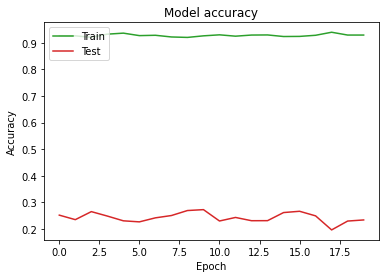

In [50]:
def plot_hist(history):
    plt.plot(history.history['accuracy'],c='C2')
    plt.plot(history.history['loss'],c='C3')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

In [45]:
results = model.evaluate(test_generator, batch_size=32)
print(results)

790/790 [==============================] - 430s 545ms/step - loss: 0.3852 - accuracy: 0.8912
[0.38522854447364807, 0.8912475109100342]


In [46]:
%cd /kaggle/working/
model.save('ModelFood21.h5')

/kaggle/working
